In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from dataloader import get_single_hits, get_event_hits, get_event_charge
from sklearn.model_selection import train_test_split

from scipy import constants
import seaborn as sns

import gc

import dragoman as dm

In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
tf.test.is_gpu_available()

True

In [5]:
labels = ['x', 'y', 'z', 'time', 'azimuth','zenith', 'cascade_energy', 'track_energy']

In [6]:
hits_list = []
charges_list = []
params_list = []

q_charges_list = []
q_params_list = []

for i in range(20):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        hits, charges, params = get_single_hits(
            fname,
            labels = labels,
            )
        hits_list.append(hits)
        charges_list.append(charges)
        params_list.append(params)
        
        
        qc, qp = get_event_charge(
            fname,
            labels = labels,
            )
        q_charges_list.append(qc)
        q_params_list.append(qp)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

hits = np.concatenate(hits_list)
charges = np.concatenate(charges_list)
params = np.concatenate(params_list)

q_charges = np.concatenate(q_charges_list)
q_params = np.concatenate(q_params_list)

Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


100%|██████████| 13066/13066 [00:47<00:00, 277.10it/s]


Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001000.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001100.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001200.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001300.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001400.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001500.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001600.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001700.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001800.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001900.hdf5


In [7]:
hits_train, hits_test, charges_train, charges_test, params_train, params_test = train_test_split(hits, charges, params, test_size=0.1, random_state=42)
q_charges_train, q_charges_test, q_params_train, q_params_test = train_test_split(q_charges, q_params, test_size=0.1, random_state=42)

In [8]:
azimuth_idx = labels.index('azimuth')
zenith_idx = labels.index('zenith')
time_idx = labels.index('time')
x_idx = labels.index('x')
y_idx = labels.index('y')
z_idx = labels.index('z')
cascade_energy_idx = labels.index('cascade_energy')
track_energy_idx = labels.index('track_energy')


speed_of_light = constants.c * 1e-9 # c in m / ns

    
class trafo_indep(tf.keras.layers.Layer):
    '''Class to transfor inputs for Hit Net
    Independent angles
    '''
    def call(self, hit, params):
        
        
        cosphi = tf.math.cos(params[:, azimuth_idx])
        sinphi = tf.math.sin(params[:, azimuth_idx])
        
        sintheta = tf.math.sin(params[:, zenith_idx])
        dir_x = sintheta * cosphi
        dir_y = sintheta * sinphi
        dir_z = tf.math.cos(params[:, zenith_idx])
        
        dx = params[:, x_idx] - hit[:,0]
        dy = params[:, y_idx] - hit[:,1]
        dz = params[:, z_idx] - hit[:,2]
        
        
        rho = tf.math.sqrt(tf.math.square(dx) + tf.math.square(dy))
        dist = tf.math.sqrt(tf.math.square(dx) + tf.math.square(dy) + tf.math.square(dz))     
        
        absdeltaphidir = tf.abs(tf.math.acos(
                                tf.clip_by_value(-tf.math.divide_no_nan((cosphi*dx + sinphi*dy), rho),
                                                 clip_value_min = -1.,
                                                 clip_value_max = +1.,
                                                )
                                            )
                                )
        costheta = tf.math.divide_no_nan(rho, dist)

        dt = hit[:,3] - params[:, time_idx]
              
        # difference c*t - r
        delta = dt * speed_of_light - dist

        cascade_energy = params[:, cascade_energy_idx]
        track_energy = params[:, track_energy_idx]
        
        out = tf.stack([
                 delta,
                 dist,
                 costheta,
                 absdeltaphidir,
                 dir_x,
                 dir_y,
                 dir_z,
                 dx,
                 dy,
                 dz,
                 cascade_energy,
                 track_energy
                ],
                axis=1
                )    
            
        return out
    
    
class trafo_q(tf.keras.layers.Layer):
    '''Class to transfor inputs for Charget Net
    '''
    def call(self, charge, params):
        
        dir_x = tf.math.sin(params[:, zenith_idx]) * tf.math.cos(params[:, azimuth_idx])
        dir_y = tf.math.sin(params[:, zenith_idx]) * tf.math.sin(params[:, azimuth_idx])
        dir_z = tf.math.cos(params[:, zenith_idx])

        cascade_energy = params[:, cascade_energy_idx]
        track_energy = params[:, track_energy_idx]

        
        out = tf.stack([
                 charge[:,0],
                 params[:, x_idx],
                 params[:, y_idx],
                 params[:, z_idx],
                 dir_x,
                 dir_y,
                 dir_z,
                 cascade_energy,
                 track_energy
                ],
                axis=1
                )            

                
        return out

In [9]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        
    def on_test_batch_end(self, batch, logs={}):
        self.test_losses.append(logs.get('loss'))
   

In [234]:
activation='relu'


hits_input = tf.keras.Input(shape=(4,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo_indep()

h = t(hits_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)


hit_net = tf.keras.Model(inputs=[hits_input, params_input], outputs=outputs)


hit_net.summary()

my_history = LossHistory()


loss_history = []
val_loss_history = []

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
trafo_indep_11 (trafo_indep)    (None, 12)           0           input_27[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 32)           416         trafo_indep_11[0][0]             
____________________________________________________________________________________________

In [333]:
activation='relu'


charge_input = tf.keras.Input(shape=(1,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo_q()

h = t(charge_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
#h = tf.keras.layers.Dense(256, activation="relu")(h)
#h = tf.keras.layers.Dropout(0.001)(h)
#h = tf.keras.layers.Dense(256, activation="relu")(h)
#h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)


charge_net = tf.keras.Model(inputs=[charge_input, params_input], outputs=outputs)


charge_net.summary()

my_history_q = LossHistory()


loss_history_q = []
val_loss_history_q = []

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
trafo_q_2 (trafo_q)             (None, 9)            0           input_29[0][0]                   
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 32)           320         trafo_q_2[0][0]                  
____________________________________________________________________________________________

In [300]:
optimizer = tf.keras.optimizers.Adam(0.00001)

hit_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [334]:
optimizer = tf.keras.optimizers.Adam(0.00001)

charge_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [12]:
def shuffle(hits, params, each_row=True):
    shuffled_hits = np.vstack([hits, hits])
    if each_row:
        shuf = np.empty_like(params)
        for col in range(params.shape[1]):
            indices = np.random.permutation(np.arange(params.shape[0]))
            shuf[:, col] = params[indices, col]
    else:
        shuf = np.random.permutation(params)
    shuffled_params = np.vstack([params, shuf])
    target = np.concatenate([np.ones(hits.shape[0]), np.zeros(hits.shape[0])])
    return shuffled_hits, shuffled_params, target

In [ ]:
%%time
for i in range(200):
    
    shuffled_hits_train, shuffled_params_train, outputs_train = shuffle(hits_train, params_train)
    shuffled_hits_test, shuffled_params_test, outputs_test = shuffle(hits_test, params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    hit_net.fit([shuffled_hits_train, shuffled_params_train], outputs_train, batch_size=512, epochs=1, validation_data=([shuffled_hits_test, shuffled_params_test], outputs_test), callbacks=[my_history,])

    loss_history.append(hit_net.history.history['loss'])
    val_loss_history.append(hit_net.history.history['val_loss'])
   

Epoch 121
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 44s 7us/sample - loss: 0.1883 - val_loss: 0.1889
Epoch 122
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 44s 7us/sample - loss: 0.1879 - val_loss: 0.1894
Epoch 123
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 44s 7us/sample - loss: 0.1878 - val_loss: 0.1894
Epoch 124
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 44s 7us/sample - loss: 0.1877 - val_loss: 0.1887
Epoch 125
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 44s 7us/sample - loss: 0.1880 - val_loss: 0.1884
Epoch 126
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 44s 7us/sample - loss: 0.1879 - val_loss: 0.1889
Epoch 127
Train on 673

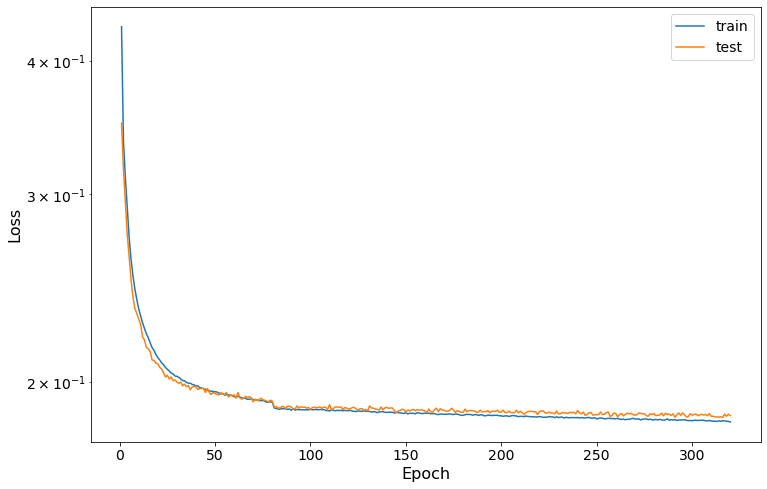

In [321]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
#plt.savefig('train.png')

In [322]:
#hit_net.save('homogeneous_indep_hit_net.h5')

In [11]:
hit_net = tf.keras.models.load_model('homogeneous_indep_hit_net.h5', custom_objects={'trafo_indep':trafo_indep})

Epoch 201
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 5s 23us/sample - loss: 0.4452 - val_loss: 0.4430
Epoch 202
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 5s 23us/sample - loss: 0.4456 - val_loss: 0.4448
Epoch 203
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 5s 23us/sample - loss: 0.4459 - val_loss: 0.4509
Epoch 204
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 5s 23us/sample - loss: 0.4458 - val_loss: 0.4473
Epoch 205
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 5s 24us/sample - loss: 0.4444 - val_loss: 0.4439
Epoch 206
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 5s 24us/sample - loss: 0.4445 - val_loss: 0.4438
Epoch 207
Train on 213540 samples, validate on

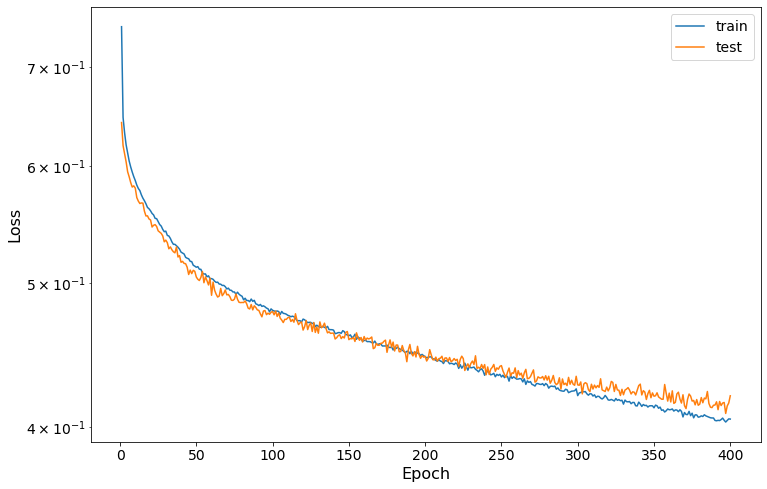

In [341]:
for i in range(200):
    
    shuffled_q_charges_train, shuffled_q_params_train, outputs_q_train = shuffle(q_charges_train, q_params_train)
    shuffled_q_charges_test, shuffled_q_params_test, outputs_q_test = shuffle(q_charges_test, q_params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history_q)+1))
    
    charge_net.fit([shuffled_q_charges_train.flatten()[:, np.newaxis], shuffled_q_params_train], outputs_q_train, batch_size=128, epochs=1, validation_data=([shuffled_q_charges_test.flatten()[:, np.newaxis], shuffled_q_params_test], outputs_q_test), callbacks=[my_history_q,])

    loss_history_q.append(charge_net.history.history['loss'])
    val_loss_history_q.append(charge_net.history.history['val_loss'])
    

fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history_q)+1)
ax.plot(x, np.concatenate(loss_history_q), label='train')
ax.plot(x, np.concatenate(val_loss_history_q), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [348]:
charge_net.save('charge_net_400.h5')

In [12]:
charge_net = tf.keras.models.load_model('charge_net_400.h5', custom_objects={'trafo_q':trafo_q})

In [13]:
hf, cf, pf = get_event_hits('../test_data/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', labels=labels, N_events=None)
qf, pqf = get_event_charge('../test_data/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', labels=labels, N_events=None)


100%|██████████| 13222/13222 [00:47<00:00, 279.41it/s]


In [218]:
def get_llhs(hits, charges, hitcharges, params, epsilon = 1e-10, subtract=True):
    
    if params.ndim == 1:
        params = np.array([params])
    
    N = params.shape[0]
    n_hits = hits.shape[0]
    
    q_charges = np.repeat(charges, repeats=N)
    q_llh = charge_net.predict([q_charges[:, np.newaxis], params], batch_size=4096)
    q_llh = q_llh[:, 0]
    q_llh = np.clip(q_llh, epsilon, 1-epsilon)
    q_llh = -(np.log(q_llh) - np.log(1 - q_llh))
    
    
    if len(hits) > 0:
        params = np.repeat(params[np.newaxis, :], repeats=n_hits, axis=0).reshape(n_hits*N, -1)
        hits = np.repeat(hits[:, np.newaxis, :], repeats=N, axis=1).reshape(n_hits*N, -1)

        #%time
        likelihood = hit_net.predict([hits, params], batch_size=2**14)
        likelihood = likelihood.reshape(n_hits, N)
        likelihood = np.clip(likelihood, epsilon, 1-epsilon)
        llhs = -(np.log(likelihood) - np.log(1 - likelihood))
        
        
        all_hits = hitcharges @ llhs
        if subtract:
            all_hits -= np.min(all_hits)
        
    else:
        all_hits = 0.
        llhs = np.array([])

    if subtract:
        q_llh -= np.min(q_llh)
    
    total_llh = all_hits + q_llh
    
    if subtract:    
        total_llh -= np.min(total_llh)
    
    return llhs.T, all_hits, q_llh, total_llh

In [15]:
def get_llh_2d(event_idx, plot_dim_x, plot_dim_y, n_steps=100):
    plot_idx_x = labels.index(plot_dim_x)
    true_p_x = pf[event_idx][plot_idx_x]
    plot_idx_y = labels.index(plot_dim_y)
    true_p_y = pf[event_idx][plot_idx_y]

    if plot_dim_x == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim_x == 'azimuth':
        xs = np.linspace(0, 2*np.pi, n_steps)
    elif 'energy' in plot_dim_x:
        xs = np.linspace(0, min(max(10, 10*true_p_x), 1000), n_steps)
    else:
        delta = 150
        if plot_dim_x == 'time':
            delta *= 3
        xs = np.linspace(true_p_x-delta, true_p_x+delta, n_steps)

        
    if plot_dim_y == 'zenith':
        ys = np.linspace(0, np.pi, n_steps)
    elif plot_dim_y == 'azimuth':
        ys = np.linspace(0, 2*np.pi, n_steps)
    elif 'energy' in plot_dim_y:
        ys = np.linspace(0, min(max(10, 10*true_p_y), 1000), n_steps)
    else:
        delta = 150
        if plot_dim_y == 'time':
            delta *= 3
        ys = np.linspace(true_p_y-delta, true_p_y+delta, n_steps)    

    p = dm.GridData(**{plot_dim_x:xs, plot_dim_y:ys})
    
    params = np.repeat(pf[event_idx][np.newaxis, :], repeats=p.grid.size, axis=0)
    params[:, plot_idx_x] = p[plot_dim_x].flatten()
    params[:, plot_idx_y] = p[plot_dim_y].flatten()
    
    
    llhs, all_hits, q_llh, total_llh = get_llhs(hf[event_idx], qf[event_idx], cf[event_idx], params)
    
    p['q_llh'] = q_llh.reshape(p.grid.shape)
    p['llhs'] = llhs.reshape(p.grid.shape + (-1,))
    p['llh'] = all_hits.reshape(p.grid.shape)
    p['tot'] = total_llh.reshape(p.grid.shape)
    
    return p, (true_p_x, true_p_y)

In [16]:
def get_llh_1d(event_idx, plot_dim, n_steps=100):

    plot_idx = labels.index(plot_dim)
    true_p = pf[event_idx][plot_idx]

    if plot_dim == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim == 'azimuth':
        xs = np.linspace(0, 2*np.pi, n_steps)
    elif 'energy' in plot_dim:
        xs = np.linspace(0, min(max(10, 10*true_p), 1000), n_steps)
    else:
        delta = 50
        if plot_dim == 'time':
            delta *= 3
        xs = np.linspace(true_p-delta, true_p+delta, n_steps)    

    params = np.repeat(pf[event_idx][np.newaxis, :], repeats=n_steps, axis=0)#.reshape(-1, 2)
    params[:, plot_idx] = xs
    
    return xs, get_llhs(hf[event_idx], qf[event_idx], cf[event_idx], params)

CPU times: user 37.9 s, sys: 3.2 s, total: 41.1 s
Wall time: 4.94 s


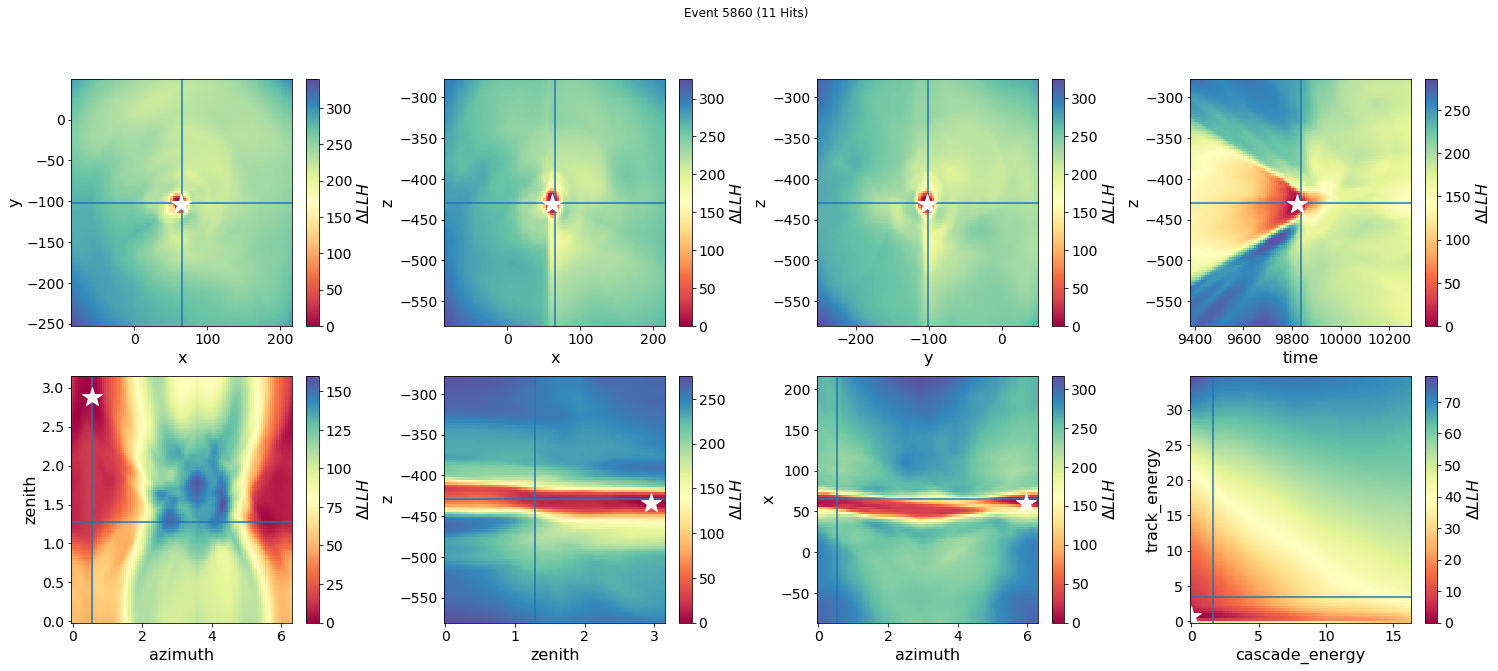

In [17]:
%%time
#event_idx = 666 # 666 #4242
event_idx = np.random.randint(0, len(pf)-1) #12321 #1657

fig, ax = plt.subplots(2,4, figsize=(25, 10))
plt.subplots_adjust(wspace=0.35)

def plot_2d(x, y, ax):
    p, t = get_llh_2d(event_idx, x, y, n_steps=100)
    p.plot('tot', cbar=True, cmap='Spectral', ax=ax, label=r'$\Delta LLH$')
    ax.axvline(t[0])
    ax.axhline(t[1])
    max_idx = np.unravel_index(np.argmin(p['tot']), p.grid.shape)
    ax.plot(p[x][max_idx],  p[y][max_idx], marker='*', color='w', lw=0, ms=20, label='MLE')

    
plot_2d('x', 'y', ax[0,0])
plot_2d('x', 'z', ax[0,1])
plot_2d('y', 'z', ax[0,2])
plot_2d('time', 'z', ax[0,3])
plot_2d('azimuth', 'zenith', ax[1,0])
plot_2d('zenith', 'z', ax[1,1])
plot_2d('azimuth', 'x', ax[1,2])
plot_2d('cascade_energy', 'track_energy', ax[1,3])

fig.suptitle('Event %i (%i Hits)'%(event_idx,hf[event_idx].shape[0]))
plt.savefig('plots/Event_%i.png'%event_idx, dpi=300)

In [18]:
def plot_llh(event_idx, plot_dim, ax, n_steps=100):
    n_hits = hf[event_idx].shape[0]
    
    colors = plt.cm.Wistia(np.linspace(0,1,n_hits))
    plot_idx = labels.index(plot_dim)

    xs, (llhs, all_hits, q_llh, total_llh) = get_llh_1d(event_idx, plot_dim, n_steps=n_steps)
    
    #llh = np.nan_to_num(llh)
    
    for i in range(n_hits):
        label = 'Single Hit' if i == n_hits//2 else None
        ax.plot(xs, llhs[:,i] - np.min(llhs[:,i]), c=colors[i], alpha=0.8, label=label)
    
    ax.axvline(pf[event_idx][plot_idx], c='r', label='truth')
    ax.plot(xs, all_hits, c='deepskyblue', ls='-', lw=2, label='All Hits')
    ax.plot(xs, q_llh, c='green', lw=2, label='Charge')
    ax.plot(xs, total_llh, c='k', lw=2, label='Total')
    ax.axvline(xs[np.argmin(total_llh)], c='k', ls='--', label='Minimum')
    
    ax.set_xlabel(plot_dim)
    #plt.legend()

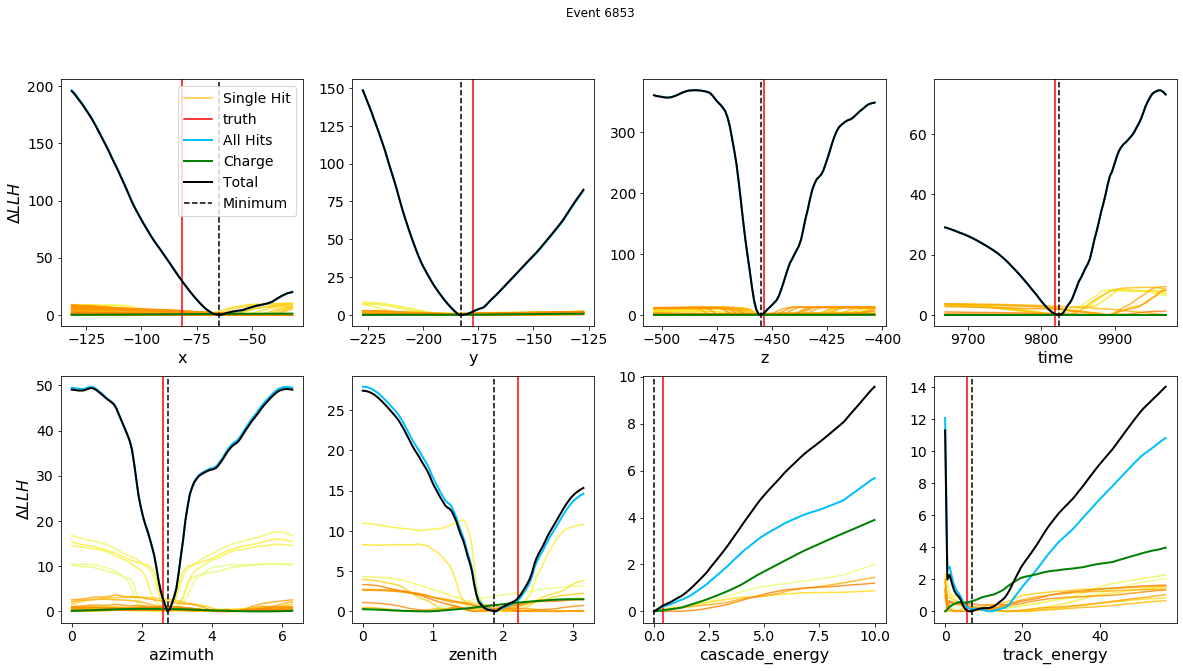

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10)) #, sharey=True)

for i in range(ax.size):

    axis = ax[i//4, i%4]

    
    if i >= len(labels):
        axis.set_axis_off()
        continue
    
    #evt = 1756 
    evt = np.random.randint(0, len(pf)-1)
    #evt = 666
    #evt = 12561
    
    plot_llh(evt, labels[i], axis, n_steps=100) #1756, 987
    
    if i == 0:
        axis.legend()
        
        
    if i%4 == 0:
        axis.set_ylabel(r'$\Delta LLH$')

        
fig.suptitle('Event %i'%evt)
        
plt.savefig('plots/hitnet_event%i.png'%evt)

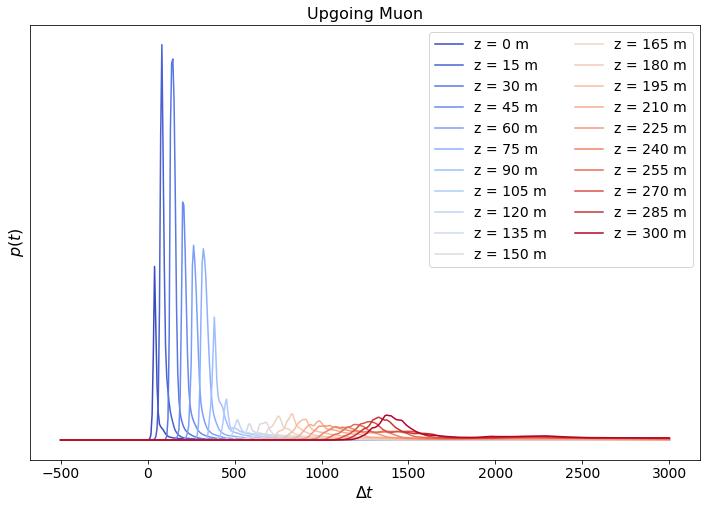

In [241]:
N = 21


colors = plt.cm.coolwarm(np.linspace(0,1,N))

for i, z in enumerate(np.linspace(0, 300, N)):

    p = np.repeat(np.array([0., 0., 0., 0, 0., np.pi, 20., 100.]), 500).reshape(8, -1).T


    p[:, 3] = np.linspace(-3000, 500, p.shape[0])


    _, l, _, _, = get_llhs(np.array([[5.,5., z, 0.]]), [1.], [1.], p, epsilon = 1e-10, subtract=False)

    plt.plot(-p[:, 3], np.exp(-l), color=colors[i], label='z = %.0f m'%z)
plt.legend(ncol=2)
plt.gca().get_yaxis().set_ticks([])
plt.gca().set_title('Upgoing Muon')
plt.gca().set_xlabel(r'$\Delta t$')
plt.gca().set_ylabel(r'$p(t)$')
plt.savefig('upgoing_muon.png')

In [28]:
labels

['x', 'y', 'z', 'time', 'azimuth', 'zenith', 'cascade_energy', 'track_energy']

In [231]:
qs = []
N = 21

charges = np.linspace(10, 500, 100)
xs = np.logspace(0, 3, N)
xs = np.linspace(0, 500, N)

for charge in charges:
    p = np.repeat(np.array([0., 0., -300., 0, np.pi, 0, 0., 0.]), N).reshape(8, -1).T
    p[:, 6] = xs
    _, l, q, _, = get_llhs(np.array([]), [charge], [1.], p, epsilon = 1e-10, subtract=False)
    qs.append(q)

qs = np.array(qs)

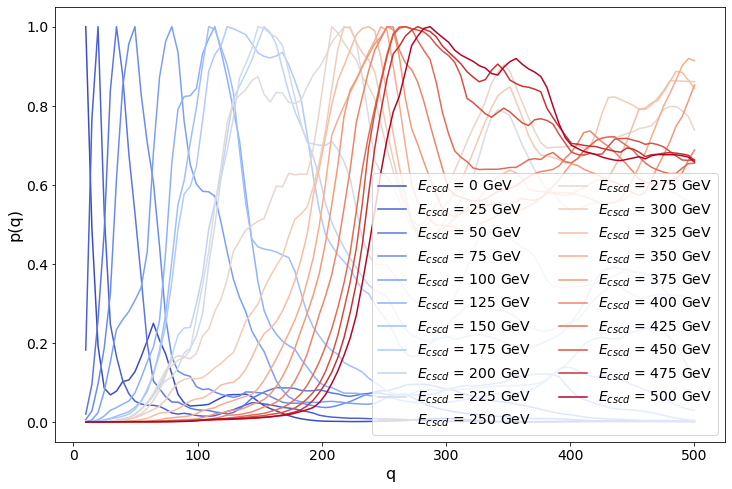

In [236]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(xs)))

for i in range(len(xs)):
    q = qs[:,i]
    #q -= np.min(q)
    plt.plot(charges, np.exp(-q), color = colors[i], label=r'$E_{cscd}$ = %i GeV'%xs[i]);
    
plt.gca().set_xlabel('q')
plt.gca().set_ylabel('p(q)')
plt.legend(loc="lower right", ncol=2)

In [ ]:

fig, ax = plt.subplots(4, 4, figsize=(20, 20))


N = 201

charges = np.linspace(20, 170, 16)


for i in range(len(charges)):
    
    g = dm.GridData(x = np.linspace(-50, 150, N), y= np.linspace(-150, 50, N))

    par = np.array([0., 0., -250., 0, np.pi, 0, 25., 0.])

    p = np.repeat(par, N*N).reshape(8, -1).T
    p[:, 0] = g['x'].flatten()
    p[:, 1] = g['y'].flatten()
    _, l, q, _, = get_llhs(np.array([]), [charges[i]], [1.], p, epsilon = 1e-10, subtract=False)


    g['q'] = q.reshape(g.grid.shape)
    g['p'] = np.exp(-g['q'])

    axis = ax[i//4, i%4]
    
    g.plot('p', cmap='bone_r', ax=axis)
    axis.set_title('Q = %.0f'%charges[i])
    
    if not i//4 == 3:
        axis.get_xaxis().set_visible(False)
    if i%4:
        axis.get_yaxis().set_visible(False)
        
    
    
    axis.plot(geo[:, 0, 0], geo[:, 0, 1], '+', color='b')
        
plt.savefig('cascade_25GeV.png')